# Implementing a Low Rank Adapter (LoRA) (8 points)

### Student : Bazaz Samuel 

Objective of this exercice:

Given a neural network (NN) classifier pre-trained on the subset of MNIST containing digits 0...4,
you will fine-tune this NN, by optimizing all weights, and compare the test accuracy of this baseline model versus fine-tuning a LoRA.

The neural network that we will define is artificially big because LoRA is usually applied to Large Language Models of billions of parameters

**What is a LoRA ?**

LoRA (Low-Rank Adaptation of Large Language Models) is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.

<div style="display: flex; justify-content: space-between;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_fig.png' style="width: 30%;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_text.png' style="width: 70%;">
</div>



References: 

https://arxiv.org/pdf/2106.09685.pdf

https://lightning.ai/pages/community/tutorial/lora-llm/

https://huggingface.co/docs/diffusers/main/en/training/lora


In [3]:
############
# Packages #
############
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.utils.parametrize as parametrize
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

##################
# added Packages #
##################
import os
import math
import plotly.express as px
import plotly.io as pio
import pandas as pd
from pathlib import Path
from torch.nn import functional as F


##########
# Config #
##########

# Make torch deterministic
_ = torch.manual_seed(0)


# Decide which device we want to run on
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


################
# added Config #
################
root_path = Path(os.getcwd())
pio.renderers.default = "plotly_mimetype+notebook"

NVIDIA GeForce GTX 1070 with Max-Q Design
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
###############
# 0-4 loaders #
###############

#Normalizing MNIST
#These values are the mean and std deviation of the MNIST dataset.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# load MNIST 
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# keep images of desired labels
class_names = [0, 1, 2, 3, 4]

# create a mask to filter indices for each label
train_mask = torch.tensor([label in class_names for label in mnist_train.targets])
test_mask = torch.tensor([label in class_names for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset = Subset(mnist_train, torch.where(train_mask)[0])
test_dataset = Subset(mnist_test, torch.where(test_mask)[0])

# split train into train & validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size=128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
len(train_dataset),len(val_dataset),len(test_dataset)

(21417, 9179, 5139)

# Architecture of the classifier

In [3]:
##############
# Classifier #
##############

#note that last layer has 5 neurons for digits 0...4
#and the same layer will be used for 5...9

class classifier(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super(classifier,self).__init__()
        
        self.linear1 = nn.Linear(28*28, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, 5)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x

net = classifier().to(device)

# Code for training loop & validation

In [20]:
##########
# Train  #
##########

#We set a lower learning rate when we will fine-tune on the subset of MNIST containing digits 5...9
#so that fine-tuning don't change pre-training weights too much.

#Since the NN is big, we add weight decay to regularize it otherwise it will overfit too much too fast
def adjust_optimizer(name, parameters):
    lr = 0.001
    if name == "subset2":
        lr = 0.00001
    return torch.optim.Adam(parameters, lr=lr, weight_decay=0.0001)

#to do label prediction during training we use argmax on the last layer, which output a vector of 5 components
#so y_hat will be between 0 and 4, we thus have to "translate" y_true so that it's in the right range

# the name variable will be used later on to recognize on which dataset we are
# and do the corresponding label translation, and set the good hyperparameters
def process_labels(name, labels):
    if 'subset2' in name:
        labels = labels - 5
    return labels


def run_epoch(loader, name, net, optimizer, cross_el, total_iterations_limit=None):
    net.train() if optimizer else net.eval()
    
    loss_sum = 0
    num_iterations = 0

    data_iterator = tqdm(loader, desc=f'Training' if optimizer else f'Validation')
    if total_iterations_limit is not None:
        data_iterator.total = total_iterations_limit

    for data in data_iterator:
        num_iterations += 1
        x, y = data
        x, y = x.to(device), y.to(device)
        x = x.view(-1, 28*28)
        optimizer.zero_grad() if optimizer else None
        output = net(x)
        loss = cross_el(output, process_labels(name, y))

        loss_sum += loss.item()
        avg_loss = loss_sum / num_iterations
        data_iterator.set_postfix(loss=avg_loss)
        if optimizer:
            loss.backward()
            optimizer.step()
    return loss_sum / len(data_iterator)

def train(train_loader, val_loader, name, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = adjust_optimizer(name, net.parameters())
    total_iterations = 0
    train_loss_lst, val_loss_lst = [], []

    for epoch in range(epochs):
        train_loss = run_epoch(train_loader, name, net, optimizer, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss}")
        train_loss_lst.append(train_loss)
            
        val_loss = run_epoch(val_loader, name, net, None, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Validation Loss: {val_loss}")
        val_loss_lst.append(val_loss)
        
    return train_loss_lst, val_loss_lst

# If you have GPU access, or simply want to train your own model, run this code

In [ ]:
train_loss_lst, val_loss_lst = train(train_loader, val_loader, "subset1", net, epochs=30)

In [ ]:
px.line(pd.DataFrame({"Train loss": train_loss_lst, "Valid loss": val_loss_lst}), title = "Train 0-4").show()

On utilise les cellules suivantes pour sauvegarder et load le modèle:

In [5]:
path1=str(root_path.joinpath("lora_m1.pth"))
path2=str(root_path.joinpath("lora_m1_dct.pth"))
print(path1, path2)

In [ ]:
# save the model
torch.save(net,path1)
# Save the state dictionary
torch.save(net.state_dict(), path2)

In [42]:
net=torch.load(path1).to(device)

# Otherwise load an already pre-trained model
Either the one you have created above, either the one already available at https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/models/ 


In [19]:
net=torch.load(path1).to(device)

# Count the number of weights & compare it with parameters added by LoRA

In [8]:
# Print the size of the weights matrices of the network
# Save the count of the total number of parameters
net.eval()
total_parameters_original = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([5, 2000]) + B: torch.Size([5])
Total number of parameters: 2,797,005


# Test the model on digits 0...4

In [6]:
##################
# Test pipeline  #
##################
def test(loader, name, net, wrong_counts):
    correct = 0
    total = 0
    
    net.eval()
    with torch.no_grad():
        for data in tqdm(loader, desc=name):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y = process_labels(name, y)
            output = net(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                else:
                    wrong_digit = y[idx].item() + 5 if 'subset2' in name else y[idx].item()
                    wrong_counts[wrong_digit] += 1
                    
                total += 1

    accuracy = round(correct / total, 3)
    print(f'Accuracy: {accuracy}')
    for key, value in wrong_counts.items():
        print(f'Wrong counts for the digit {key}: {value}')
        
    return accuracy

In [ ]:
test(test_loader, "Test 0-4", net, {i: 0 for i in range(5)})

# Define train, validation, test sets for digits 5...9

__Question 1 (0.25 points) :__

In [7]:
###############
# 1-5 loaders #
###############

#TO-DO#-----------------------

# create a mask to filter indices for each label, retrieve digits 5...9

# load MNIST 
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
## On change le choix des labels
# keep images of desired labels
class_names2 = [5, 6, 7, 8, 9]

# create a mask to filter indices for each label
train_mask_subset2 = torch.tensor([label in class_names2 for label in mnist_train.targets])
test_mask_subset2 = torch.tensor([label in class_names2 for label in mnist_test.targets])

##------------------------------

# Create Subset datasets for train, validation, and test
train_dataset_subset2 = Subset(mnist_train, torch.where(train_mask_subset2)[0])
test_dataset_subset2 = Subset(mnist_test, torch.where(test_mask_subset2)[0])

# split train into train & validation
train_size_subset2 = int(0.7 * len(train_dataset_subset2))
val_size_subset2 = len(train_dataset_subset2) - train_size_subset2
train_dataset_subset2, val_dataset_subset2 = random_split(train_dataset_subset2, [train_size_subset2, val_size_subset2])

train_loader_subset2 = DataLoader(train_dataset_subset2, batch_size=batch_size, shuffle=True)
val_loader_subset2 = DataLoader(val_dataset_subset2, batch_size=batch_size, shuffle=False)
test_loader_subset2 = DataLoader(test_dataset_subset2, batch_size=batch_size, shuffle=False)

len(train_dataset_subset2),len(train_dataset_subset2),len(test_dataset_subset2)

(20582, 20582, 4861)

Le volume de données n'est pas très différent du cas 0-4.

# Verify that pre-trained model on digits 0...4 is bad on digits 5...9

__Question 2 (0.25 points) :__

You should display the number of wrong predictions for each digits & global accuracy. \
Note that it's better than random guess ($\frac{1}{5}\times 100= $20%) for digit 8 and 9 because 3 looks like 8 and 4 looks like 9


In [27]:
#TO-DO#-----------------------
test(test_loader_subset2, "Test subset2", net, {i: 0 for i in range(5,10)})
##------------------------------

Test subset2: 100%|██████████| 38/38 [00:03<00:00, 11.67it/s]

Accuracy: 0.4
Wrong counts for the digit 5: 809
Wrong counts for the digit 6: 935
Wrong counts for the digit 7: 651
Wrong counts for the digit 8: 400
Wrong counts for the digit 9: 122


0.4

Effectivement, l'algorithme performe bien que le hazard pour le 8 et le 9 !

# Fine-tune the model on digits 5...9

__Question 3 (0.5 points) :__

You will fine-tune all the layers of the model (ie. all parameters of all fully-connected matrices) for 10 epochs

On réentraine le réseau:

In [ ]:
#TO-DO#-----------------------

train_loss_lst, val_loss_lst = train(train_loader_subset2, val_loader_subset2, "subset2", net, epochs=10)

#plot the train and validation losses
px.line(pd.DataFrame({"Train loss": train_loss_lst, "Valid loss": val_loss_lst}), title = "Train 5-9").show()

##------------------------------

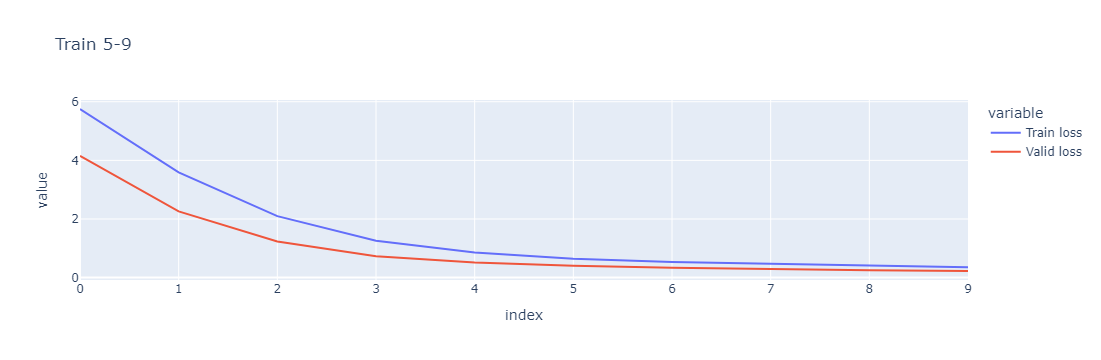

In [26]:
#test accuracy of fine-tuned model on digits 5...9
# & save this number into a variable, we will need it for final plot
#TO-DO#-----------------------

score_10epoch = test(test_loader_subset2, "Test subset2 after retraining", net, {i: 0 for i in range(5,10)})

##------------------------------

Test subset2 after retraining: 100%|██████████| 38/38 [00:01<00:00, 25.10it/s]

Accuracy: 0.929
Wrong counts for the digit 5: 70
Wrong counts for the digit 6: 39
Wrong counts for the digit 7: 76
Wrong counts for the digit 8: 93
Wrong counts for the digit 9: 69


Après réentrainement on retrouve une performance comparable au cas 0-4.
On sauvegarde le modèle réentrainé à travers le script suivant:

In [8]:
path3=str(root_path.joinpath("lora_m2.pth"))
path4=str(root_path.joinpath("lora_m2_dct.pth"))

In [20]:
# save the model
torch.save(net,path3)
# Save the state dictionary
torch.save(net.state_dict(), path4)

In [25]:
net=torch.load(path3).to(device)

# Fine-tune the model on digits 5...9 with LoRA

__Question 4 (2.5 points) :__

You will now implement one LoRA per layer

En s'inspirant des tutoriels fournis, on complète l'architecture LoRa associée au Classifier précédent de la manière suivante:

In [45]:
###################
# LoRa classifier #
###################
class ModifiedClassifier(nn.Module):
    def __init__(self, lora_rank):
        super(ModifiedClassifier, self).__init__()
        
        # Load the pretrained model
        self.pretrained_net = classifier().to(device)
        self.pretrained_net.load_state_dict(torch.load(path2))
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
        # Define lora hyperparameters
        #TO-DO#-----------------------
        self.α = 1 # facteur d'échelle
        self.r = lora_rank
        self.lora_beta = nn.Parameter(torch.Tensor(lora_rank, 1))
        self.lora_gamma = nn.Parameter(torch.Tensor(lora_rank, 1))
        ##------------------------------
        
        # Define lora weights matrices for each layer in pretrained model
        #TO-DO#-----------------------
        # layer 1
        self.l1_lora_A = nn.Parameter(torch.empty(self.pretrained_net.linear1.in_features , self.r))
        self.l1_lora_B = nn.Parameter(torch.empty(self.r, self.pretrained_net.linear1.out_features ))
  
        # layer 2
        self.l2_lora_A = nn.Parameter(torch.empty(self.pretrained_net.linear2.in_features, self.r))
        self.l2_lora_B = nn.Parameter(torch.empty(self.r, self.pretrained_net.linear2.out_features))
  
        # layer 3
        self.l3_lora_A = nn.Parameter(torch.empty(self.pretrained_net.linear3.in_features, self.r))
        self.l3_lora_B = nn.Parameter(torch.empty(self.r, self.pretrained_net.linear3.out_features))
        ##------------------------------
        
        # Define lora initialization
        #TO-DO#-----------------------
        nn.init.kaiming_uniform_(self.l1_lora_A, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.l2_lora_A, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.l3_lora_A, a=math.sqrt(5))
        

        nn.init.zeros_(self.l1_lora_B)
        nn.init.zeros_(self.l2_lora_B)
        nn.init.zeros_(self.l3_lora_B)
        ##------------------------------
        
        # nn.init.kaiming_normal_(self.l1_lora_A, mode='fan_out', nonlinearity='relu')
        # nn.init.kaiming_normal_(self.l2_lora_A, mode='fan_out', nonlinearity='relu')
        # nn.init.kaiming_normal_(self.l3_lora_A, mode='fan_out', nonlinearity='relu')

        # nn.init.xavier_normal_(self.l1_lora_A)
        # nn.init.xavier_normal_(self.l2_lora_A)
        # nn.init.xavier_normal_(self.l3_lora_A)
        
        # print(self.l1_lora_A)
        # print(self.l1_lora_B)
        
        # freeze non lora weights
        #TO-DO#-----------------------
        for param in self.pretrained_net.parameters():
            param.requires_grad = False
        ##------------------------------
                
    def lora_linear(self, x, layer, lora_A, lora_B):
        #Implement formula (3) in arxiv.org/pdf/2106.09685.pdf
        #TO-DO#-----------------------
        h = layer(x) + (self.α) * x @ lora_A @ lora_B 
        return h
        ##------------------------------        
        
    def forward(self, input):
        x = input.view(-1, 28*28)
        
        # layer 1 (input size, hidden size)
        x = self.lora_linear(x, self.pretrained_net.linear1, self.l1_lora_A, self.l1_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        #complete the remaining code (layer 2 and 3)
        #TO-DO#-----------------------
        # layer 2 (hidden_size_1, hidden_size_2)
        x = self.lora_linear(x, self.pretrained_net.linear2, self.l2_lora_A, self.l2_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 3 (hidden_size_2, 5)
        x = self.lora_linear(x, self.pretrained_net.linear3, self.l3_lora_A, self.l3_lora_B)
        return F.log_softmax(x, dim=1)
        ##------------------------------

Make a function that counts the number of parameters introduced by lora ( use the function torch.numel() )

On adapte le script précédent pour le comptage de poids et on dénombre le nombre de paramètres associés aux différentes matrices de l'extension LoRa.

In [44]:
lora_rank=1
# Create an instance of the modified network
modified_net = ModifiedClassifier(lora_rank).to(device)

# Count the parameters introduced by lora layers
# Print the size of the weights matrices of the network
# Save the count of the total number of parameters
#TO-DO#-----------------------
modified_net.eval()
total_parameters_original = 0

# matrices Lora
lst_lora_layers = [
    modified_net.l1_lora_A, 
    modified_net.l1_lora_B, 
    modified_net.l2_lora_A, 
    modified_net.l2_lora_B, 
    modified_net.l3_lora_A, 
    modified_net.l3_lora_B
]

# dénombrement des paramètres
for index, layer in enumerate(lst_lora_layers):
    npara = torch.numel(layer)
    if index%2==0:
        print(f"Layer {index//2+1} : A : {npara}")
    else:
        print(f"Layer {index//2+1} : B : {npara}")
    
    total_parameters_original += npara
print(f'Total number of parameters: {total_parameters_original:,}')
##------------------------------

Layer 1 : A : 784
Layer 1 : B : 1000
Layer 2 : A : 1000
Layer 2 : B : 2000
Layer 3 : A : 2000
Layer 3 : B : 5
Total number of parameters: 6,789


On est bien loin des 2,797,005 paramètres à réentrainer !

# Fine-Tune using LoRA of rank 1

__Question 5 (0.5 points) :__

Suite à plusieurs essais concernant l'initailisation des matrices A, la loi normale a été remplacée par un nn.init.kaiming_uniform_ ce qui a permis de passer d'une accuracy de 0.42 à 0.568.

In [ ]:
#Fine tune this new model with loras of rank 1, on MNIST 5...9
#TO-DO#-----------------------
train_loss_lora1, val_loss_lora1 = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=30)
print("__________________End training__________________")
##------------------------------



In [52]:
# Check that the frozen parameters are still unchanged by the finetuning
# Remember the dictionary "original_weights"
#TO-DO#-----------------------
all_same = all( [
    False not in (v == torch.load(path2)[k]) 
    for k,v in modified_net.pretrained_net.state_dict().items()
])
print("\n All same =",all_same)
##------------------------------


 All same = True


Les poids du classifier sont bien inchangés.

In [ ]:
#plot losses
#TO-DO#-----------------------
px.line(pd.DataFrame({"Train loss": train_loss_lora1, "Valid loss": val_loss_lora1}), title = "<b>LoRa r=1</b> Train 5-9 ").show()
##------------------------------

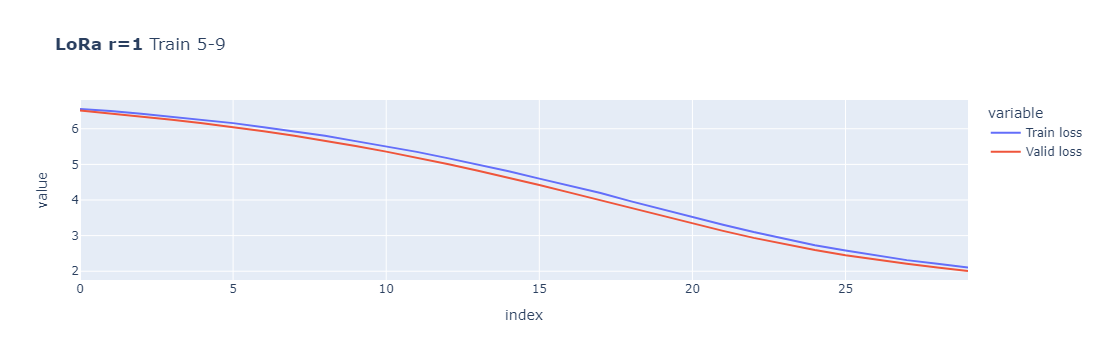

La décroissance de la loss est plus lente que dans le cas avec tous les poids, et la performance diminue du fait de la perte en expressivité du modèle:

In [67]:
#Compute test accuracy on MNIST 5...9 for that lora rank
#######
#TO-DO#
#######
score_lora1 = test(test_loader_subset2, "Test subset2 after retraining", modified_net, {i: 0 for i in range(5,10)})

Test subset2 after retraining: 100%|██████████| 38/38 [00:01<00:00, 19.91it/s]

Accuracy: 0.568
Wrong counts for the digit 5: 427
Wrong counts for the digit 6: 321
Wrong counts for the digit 7: 422
Wrong counts for the digit 8: 726
Wrong counts for the digit 9: 202


La diminution en poids c'est fait au pris d'une baisse de performance. Il peut être utile de de trouver un meilleure compromis entre complexité spatial et accuracy.

# Try different LoRA rank

__Question 6 (4 points) :__

Fine-tune the pre-trained model using different lora ranks [1,2,4,8,16,32,64], evaluate it on the test set
and store the number of parameters added 

Make a plot showing the test accuracy as a function of lora rank. \
Compare it to the test accuracy of the pre-trained model fine-tuned in the usual way on MNIST 5...9 

Conclude by looking at the number of parameters added

Discuss what are the pros of LoRA, what possible applications do you envision for it ?

In [ ]:
############
# Pipeline #
############
def lora_train_test(lora_rank):
    # définition du modèle
    modif_net = ModifiedClassifier(lora_rank).to(device)
    # comptage du nombre de paramètres à train
    modif_net.eval()
    total_parameters = 0
    lst_lora_layers = [
        modif_net.l1_lora_A, 
        modif_net.l1_lora_B, 
        modif_net.l2_lora_A, 
        modif_net.l2_lora_B, 
        modif_net.l3_lora_A, 
        modif_net.l3_lora_B
    ]

    for layer in lst_lora_layers:
        total_parameters += torch.numel(layer)

    # Train and test
    train_loss_lora, val_loss_lora = train(train_loader_subset2, val_loader_subset2, "subset2", modif_net, epochs=10)
    score_lora = test(test_loader_subset2, "Test subset2 after retraining", modif_net, {i: 0 for i in range(5,10)})
    return total_parameters, train_loss_lora, val_loss_lora, score_lora


##########################
# Script data collection #
##########################
accu_npara = []
accu_score = []
df_loss = pd.DataFrame({})

lst_rank = [1,2,4,8,16,32,64]
for lora_rank in tqdm(lst_rank):
    total_parameters, train_loss_lora, val_loss_lora, score_lora = lora_train_test(lora_rank)
    accu_npara.append(total_parameters)
    accu_score.append(score_lora)
    df_loss[f"Train loss k={lora_rank}"] = train_loss_lora
    df_loss[f"Valid loss k={lora_rank}"] = val_loss_lora

df_score = pd.DataFrame({"number of parameters":accu_npara, "Accuracy": accu_score, "Rank":lst_rank})

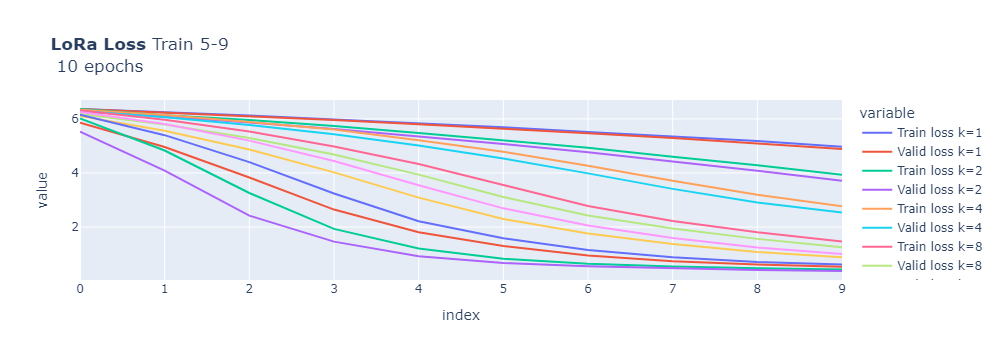

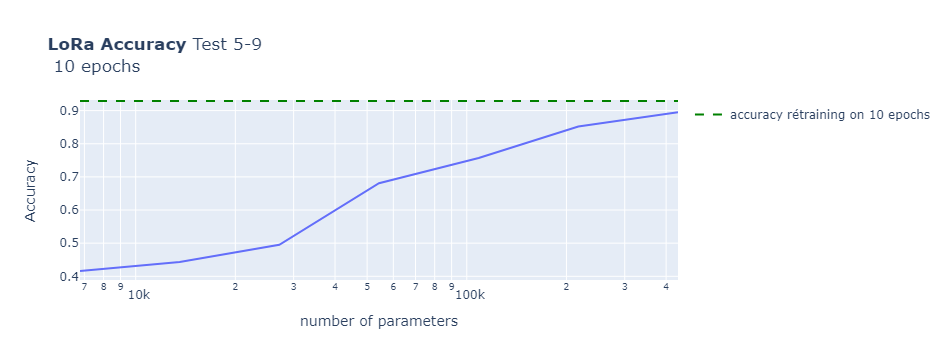

In [51]:
################
# Script plots #
################

px.line(df_loss, title = "<b>LoRa Loss</b> Train 5-9 <br> 10 epochs").show()
px.line(
        df_score, 
        x = "number of parameters", 
        y = "Accuracy",  
        title = "<b>LoRa Accuracy</b> Test 5-9 <br> 10 epochs",
        hover_data=["number of parameters", "Accuracy", "Rank"],
        log_x=True
    ).add_hline(
        y=score_10epoch, 
        line_dash="dash", 
        line_color="green",
        name='accuracy rétraining on 10 epochs',
        showlegend=True
    ).show()

Comme attendu, le rang contrôle le nombre de paramètres, donc l'expressivité du modèle, ce qui conduit à des pertes de performances plus ou moins grandes, en comparaison à un réentrainement du modèle initial (en vert ci dessus). Cependant, on rappelle que ce niveau de précision est atteint avec un réentrainement de 10 epochs sur 2,797,005 paramètres, ce qui est largement plus grand que le modèle à r=64 qui contient 434k paramètres et qui frole déjà les 0.9 d'accuracy. Le 'manifold hypothesis' de l'espace des paramètres est ici vérifié et une base locale à 8 dimensions laisse déjà suffisament de liberté au modèle pour s'adapter à la nouvelle classification, et avoir des performances correctes. On observe aussi que plus le rang est faible et plus le temps d'entraînement est long pour obtenir de bonnes performances, et ce faisant, le choix du rang doit se faire conjointement au nombre d'epochs. Le gain en précision n'est pas très éloigné d'une croissance logarithmique en le nombre de paramètres, il y a ainsi un tread off à faire entre le coût computationnel de réentrainement et les performances. Au vu des impactes envirronnementaux des entraînements de depp learning, LoRa est une méthode qui devrait être davantage enseignée et s'incrit dans le paradygme du "Frugal Machine Learning". Certes, ce n'est pas conseillé de l'utiliser pour des taches de précision (aide au diagnostique médical, détection de feu de forêt ...) mais pour des taches de classification à fort volumes et peu risquée (détection de Spam, étude marketing ...) cela offre un levier de réduction de coût très intéressant!